# 使用手写数字集训练网络，同时增加了网络模型保存和二次加载
在算法的实际使用过程中，除了设计网络，还需要考虑到训练的模型如何部署，如何调用模型进行推理预测

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image

## 1、加载数据
在实际的应用中数据可能是处理好的包结构，也可能还是原始的一张一张的图像
为了解决数据类型问题，常常先加载独立的原始数据进行一定的预处理后导出为一个独立的csv或者npz或者tf格式的数据包，在训练时直接加载数据包。

In [2]:
# 从 CSV 目录读取文件
def readImage(image_path, file_path):
    csv_file = pd.read_csv(file_path)
    # 获取列数据
    train_data_file = csv_file['train']
    train_data_label = csv_file['train_label']
    test_data_file = csv_file['test']
    test_data_label = csv_file['test_label']
    x, y_ , t, yt_= [], [], [], []
    for _index in np.arange(0, train_data_file.shape[0], 1):
        if pd.notna(train_data_file.iloc[_index]):  # 判断如果数据非空
            img_ = Image.open(image_path + train_data_file[_index])
            img_ = np.array(img_.convert('L'))
            img_ = img_ / 255.  # 数据标准归一化
            x.append(img_)
            y_.append(train_data_label[_index])
    for _index in np.arange(0, test_data_file.shape[0], 1):
        if pd.notna(test_data_file.iloc[_index]):
            img_ = Image.open(image_path + test_data_file[_index])
            img_ = np.array(img_.convert('L'))
            img_ = img_ / 255.
            t.append(img_)
            yt_.append(test_data_label[_index])
    return (x, y_), (t, yt_)

(x_train, y_train), (x_test, y_test)  = readImage(image_path='../Data/MNIST/', file_path='../Data/MNIST/file_name.csv')

### 读取标准数据集

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='E:\Code\myMachineLearning\Tensorflow2\Data\mnist.npz')

print('训练集样本的大小:', x_train.shape)
print('训练集标签的大小:', y_train.shape)
print('测试集样本的大小:', x_test.shape)
print('测试集标签的大小:', y_test.shape)

训练集样本的大小: (60000, 28, 28)
训练集标签的大小: (60000,)
测试集样本的大小: (10000, 28, 28)
测试集标签的大小: (10000,)


## 2、数据预处理，数据增强
```
img_prossess_Gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale='所有数据乘以这个数（倍乘）',
    horizontal_flip='是否随机水平旋转 Boolean',
    rotation_rang='随机旋转的角度范围 Int',
    width_shift_range='随机宽度偏移量',
    height_shift_range='随机高度便宜量',
    zoom_range='随机缩放的范围 Float or [lower, upper].'
)
```

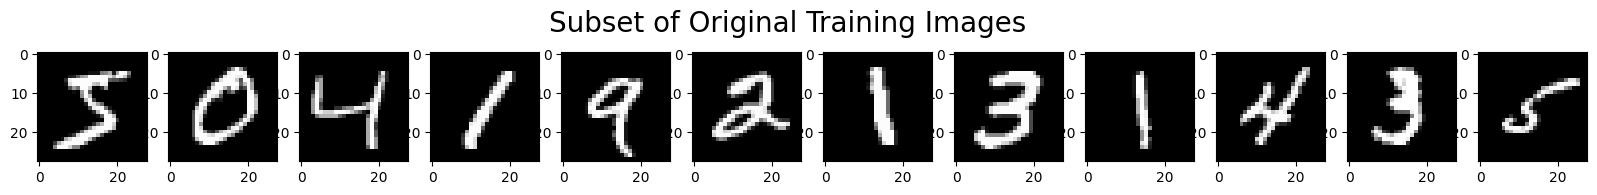

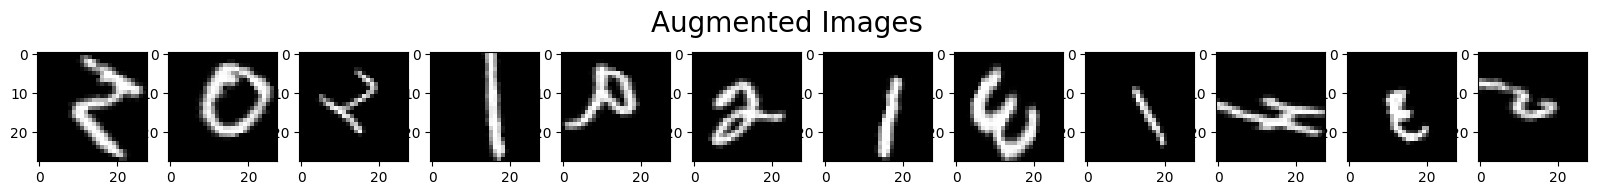

In [3]:
x_train, x_test = x_train/255.0, x_test/255.0   # 灰度图像数据归一化处理

fig = plt.figure(figsize=(20, 2))
plt.set_cmap('gray')
# 显示原始图片
for i in range(0, 12):
    ax = fig.add_subplot(1, 12, i + 1)
    ax.imshow(x_train[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

img_gen = True  # 是否使用数据增强
if img_gen is True:
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # 数据扩充要求输入的数据是四维
    img_process_Gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./1.,
        horizontal_flip=True,
        rotation_range=45,
        width_shift_range=.15,
        height_shift_range=.15,
        zoom_range=0.5
    )
    img_process_Gen.fit(x_train)

    # 显示增强后的图片
    fig = plt.figure(figsize=(20, 2))
    for x_batch in img_process_Gen.flow(x_train, batch_size=12, shuffle=False):
        for i in range(0, 12):
            ax = fig.add_subplot(1, 12, i + 1)
            ax.imshow(np.squeeze(x_batch[i]))
        fig.suptitle('Augmented Images', fontsize=20)
        plt.show()
        break

显示数据

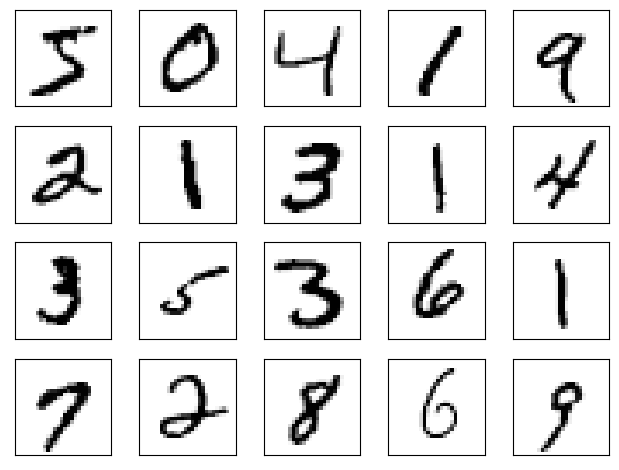

In [5]:
#可视化样本，下面是输出了训练集中前20个样本
fig, ax = plt.subplots(nrows=4,ncols=5,sharex='all',sharey='all')
ax = ax.flatten()
for i in range(20):
    img = x_train[i].reshape(28, 28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 3、构建网络
Sequential构建网络

In [4]:
class_flag = True  # 是否使用class定义网络

if not class_flag:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])

class构建网络

In [5]:
class mnistModel(Model):
    def __init__(self, *args, **kwargs):
        super(mnistModel, self).__init__(*args, **kwargs)

        self.flatten1=layers.Flatten()
        self.d1=layers.Dense(128, activation=tf.keras.activations.relu)
        self.d2=layers.Dense(10, activation=tf.keras.activations.softmax)

    def call(self, input):
        x = self.flatten1(input)
        x = self.d1(x)
        x = self.d2(x)
        return x

if class_flag:
    model = mnistModel()

## 4+5、设置网络参数、训练
为了记录更加详细的网络训练过程，可以添加过程记录回调函数
同时为了保存模型可以添加权重保存回调函数

In [6]:
# 定义保存和记录数据的回调器
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint/mnist/mnist.ckpt",  # 保存模型权重参数
                                                 save_weights_only=True,
                                                 save_best_only=True)
# 设置TensorBoard输出的回调函数
tfbd_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/mnist/")

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 , beta_1=0.9, beta_2=0.999),     # 'adam'  tf.keras.optimizers.Adam(learning_rate=0.01 , beta_1=0.9, beta_2=0.999)
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # 使用交叉熵损失
                metrics=['sparse_categorical_accuracy']
                )

if not img_gen:
    history = model.fit(x_train, y_train, batch_size=32, epochs=5,
                        validation_data = (x_test, y_test), validation_freq=1,
                        callbacks=[cp_callback, tfbd_callback])  # 设置回调函数
elif img_gen:
    history = model.fit(img_process_Gen.flow(x_train, y_train, batch_size=32), epochs=5,
                        validation_data=(x_test, y_test), validation_freq=1,
                        callbacks=[cp_callback, tfbd_callback])  # 设置回调函数

model.summary()

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 1.6055 - sparse_categorical_accuracy: 0.4609 - val_loss: 0.7877 - val_sparse_categorical_accuracy: 0.7439
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 1.2075 - sparse_categorical_accuracy: 0.6105 - val_loss: 0.5629 - val_sparse_categorical_accuracy: 0.8253
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0803 - sparse_categorical_accuracy: 0.6517 - val_loss: 0.5552 - val_sparse_categorical_accuracy: 0.8286
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0334 - sparse_categorical_accuracy: 0.6676 - val_loss: 0.4301 - val_sparse_categorical_accuracy: 0.8675
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9818 - sparse_categorical_accuracy: 0.6866 - val_loss: 0.4635 - val_sparse_categorical_accuracy: 0.8501
Model: "mnist_model"
_________________________________________________________________
Layer 

## 6、可视化和结果输出

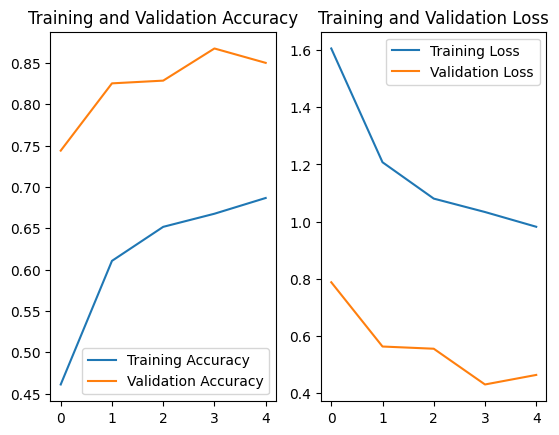

In [8]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 7、保存模型
保存模型分为动态权重保存和静态模型保存
上面回调函数保存的就是动态的权重
这里使用model.save保存静态的模型图，静态模型便于网络的部署和优化

In [9]:
model.save('./checkpoint/mnist/model', save_format='tf')    # 保存模型为静态权重

INFO:tensorflow:Assets written to: ./checkpoint/mnist/model\assets


## 加载模型，执行前向传播，进行一次新推理

使用原来训练的模型进行推理

In [12]:
# 使用原有模型进行推理，要先训练
import cv2

image_path = '../Data/MNIST/'

preNum = int(input("place input how many jpg file while be test:"))
for i in range(preNum):
    imgNum = int(input("place input png name:"))
    img_path = image_path+str(imgNum)+'.png'
    print("read image:{}".format(img_path))

    img_ = cv2.imread(img_path)
    resized_img = cv2.resize(img_, (28, 28), interpolation=cv2.INTER_AREA)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    binary_image = np.where(gray_img < 200, 255, 0).astype(np.uint8)    # 反相和过滤
    # 准备图像数据，进行归一化和添加批次维度
    img_for_prediction = binary_image.astype(np.float32) / 255.0  # 归一化到 [0, 1]
    img_for_prediction = np.expand_dims(img_for_prediction, axis=0)  # 添加批次维度

    result = model.predict(img_for_prediction)
    predNum = tf.argmax(result, axis=1)
    print("predict num is: ")
    tf.print(predNum)

read image:../Data/MNIST/1.png
predict num is: 
[1]
read image:../Data/MNIST/5.png
predict num is: 
[5]
read image:../Data/MNIST/8.png
predict num is: 
[5]


加载保存好的模型进行推理
注意灰度图的色域表示，在加载的图像中白底黑字，黑字像素接近0，白色像素接近255，训练的数据是黑底白字，背景像素为0，字体区域是255，所以实际加载的数据需要进行一次反相。
在预测时要处理好输入数据的维度：当开启了数据扩充后输入网络的张量尺寸是[批尺寸， 图片宽，图片高，位深度]，本程序中为[32,28,28,1]，所以预测阶段需要修改数据维度为[1,28,28,1]

In [13]:
# 定义新模型，然后加载保存好的模型参数预测
import cv2

image_path = '../Data/MNIST/'

model_path = './checkpoint/mnist/model'      
new_model = tf.keras.models.load_model(model_path)  # 从tf模型加载，无需重新实例化网络

# model_path = './checkpoint/mnist/mnist.ckpt' 
# new_model = mnisModel()
# new_model.load_weights(model_path)    # 从权重加载，需要先实例化网络再加载权重参数
preNum = int(input("place input how many jpg file while be test:"))
for i in range(preNum):
    imgNum = int(input("place input png name:"))
    img_path = image_path+str(imgNum)+'.png'
    print("read image:{}".format(img_path))

    img_ = cv2.imread(img_path)
    resized_img = cv2.resize(img_, (28, 28), interpolation=cv2.INTER_AREA)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    binary_image = np.where(gray_img < 200, 255, 0).astype(np.uint8)    # 反相和过滤
    # 准备图像数据，进行归一化和添加批次维度
    img_for_prediction = binary_image.astype(np.float32) / 255.0  # 归一化到 [0, 1]

    if not img_gen:
        img_for_prediction = np.expand_dims(img_for_prediction, axis=0)  # 添加批次维度，改为【nan,28,28,1】
    elif img_gen:
        img_for_prediction = img_for_prediction.reshape(1, 28, 28, 1)  # 数据扩充要求输入的数据是四维，改为【1,28,28,1】

    result = new_model.predict(img_for_prediction)
    predNum = tf.argmax(result, axis=1)
    print("predict num is: ")
    tf.print(predNum)

read image:../Data/MNIST/1.png
predict num is: 
[1]
read image:../Data/MNIST/5.png
predict num is: 
[5]
read image:../Data/MNIST/8.png
predict num is: 
[5]


加载图像时还可以使用轻量级的库 PIL，使用opencv加载则便于对数据进行二次处理

In [14]:
model_path = './checkpoint/mnist/mnist.ckpt'
image_path = '../Data/MNIST/'

new2_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

new2_model.load_weights(model_path) # 使用权重加载

preNum = int(input("input the number of test pictures:"))

for x in range(preNum):
    image_name = input("the path of test picture:")
    img = Image.open(image_path+image_name+'.png')
    img = img.resize((28, 28), Image.Resampling.LANCZOS)
    img_arr = np.array(img.convert('L'))

    for i in range(28):
        for j in range(28):
            if img_arr[i][j] < 200:
                img_arr[i][j] = 255
            else:
                img_arr[i][j] = 0

    img_arr = img_arr / 255.0
    x_predict = img_arr[tf.newaxis, ...]
    result = new2_model.predict(x_predict)

    pred = tf.argmax(result, axis=1)

    print('\n')
    tf.print(pred)



[1]


[3]


[5]
